In [1]:
import pandas as pd
import numpy as np
import dataloader
import circularPitchSpace as cps
import matplotlib.pyplot as plt
subset = 'majmin'
path = "/home/max/ET-TI/Masterarbeit/datasets/beatles/"
dataset = dataloader.BeatlesDataset(path,'madmom',False)

# let it be chroma
t,chroma,ref_interval,ref_labels = dataset[103]
rho_F,rho_FR,rho_TR,rho_DR = cps.transformChroma(chroma)


[(0.5353635897971755, 36.00049392826546), (1.1829537516069792, 29.902217727820148), (1.7165028357900354, 17.9629157607729), (1.8183149232358091, 17.106263902337727), (1.8568744335057088, 16.740096324170793), (1.8725652206799543, 16.668396745634023), (1.8835001389804844, 16.432534272624384), (1.896320459364428, 16.005303167465108), (1.9042113431755712, 15.69312737393581), (1.9093564822509346, 15.542102976241285), (1.9066877241446665, 15.746384783357527), (1.9077814525758092, 15.718201358114975), (1.9129075299603204, 15.29488904589968), (1.9158810701593372, 15.005846520741677), (1.9159691158223087, 14.842077060267115), (1.9134941765926192, 14.688583066460113), (1.9115119986955174, 14.510375526973018), (1.904088166239164, 14.05380409603063), (1.8922577432406, 12.612877336283972), (1.9708816159260172, -0.7255516583821914), (2.0923990241468995, -9.12465025950966), (1.96561198734519, -12.624432286296821), (1.917196542131122, -14.061086345049311), (1.910859591554515, -13.760813838331295), (1.

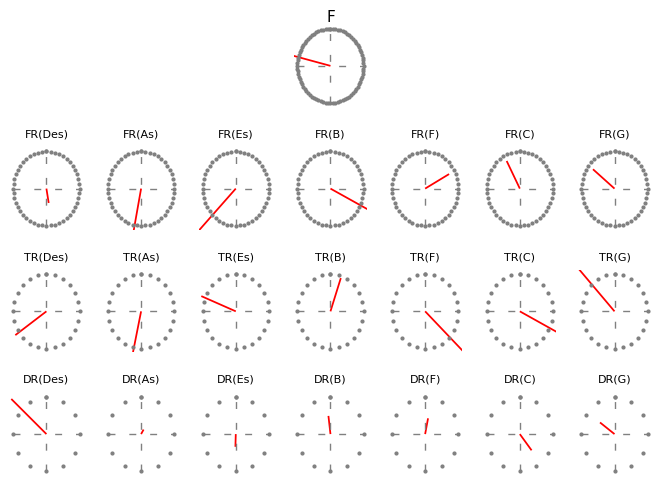

In [7]:

def plotFeatures(ax,rho_F,rho_FR,rho_TR,rho_DR):
    pass

t = 10
kwargs = {'width':0.05,'headlength':0,'headlength':0,'headaxislength':0,'units':'xy','scale':1,'color':'r'}
fig = plt.figure(figsize=((8.27,11.69/2)))
grid = plt.GridSpec(4, 7, wspace=0.3, hspace=0.5)

ax = fig.add_subplot(grid[0,3])
cps.plotHalftoneGrid(ax,84)
cps.plotVector(ax,rho_F[t],**kwargs)
ax.text(0,1.2,"F",horizontalalignment='center',fontsize=11)
ax.set_axis_off()
for i in range(7):
    ax = fig.add_subplot(grid[1,i])
    cps.plotHalftoneGrid(ax,48)
    cps.plotVector(ax,rho_FR[t][i],**kwargs)
    ax.text(0,1.4,f"FR({cps.getCircleLabel(i)})",horizontalalignment='center',fontsize=8)
    ax.set_axis_off()
    ax = fig.add_subplot(grid[2,i])
    cps.plotHalftoneGrid(ax,24)
    cps.plotVector(ax,rho_TR[t][i],**kwargs)    
    ax.text(0,1.4,f"TR({cps.getCircleLabel(i)})",horizontalalignment='center',fontsize=8)
    ax.set_axis_off()
    ax = fig.add_subplot(grid[3,i])
    cps.plotHalftoneGrid(ax,12)
    cps.plotVector(ax,rho_DR[t][i],**kwargs)
    ax.text(0,1.4,f"DR({cps.getCircleLabel(i)})",horizontalalignment='center',fontsize=8)
    ax.set_axis_off()